In [1]:
import itertools

from tf.app import use
A = use('etcbc/bhsa', hoist=globals())

from nltk import bigrams
import numpy as np
import pandas as pd
import torch
from transformers import AutoTokenizer, BertForMaskedLM

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.utils import resample

**Locating corpus resources ...**

Name,# of nodes,# slots / node,% coverage
book,39,10938.21,100
chapter,929,459.19,100
lex,9230,46.22,100
verse,23213,18.38,100
half_verse,45179,9.44,100
sentence,63717,6.70,100
sentence_atom,64514,6.61,100
clause,88131,4.84,100
clause_atom,90704,4.70,100
phrase,253203,1.68,100


* https://huggingface.co/avichr/heBERT
* https://huggingface.co/onlplab/alephbert-base
* https: //huggingface.co/dicta-il/dictabert
* https://huggingface.co/dicta-il/BEREL
* https://huggingface.co/dicta-il/BEREL_2.0


In [2]:
model_names = [
     'dicta-il/BEREL', 
    'dicta-il/BEREL_2.0',
    'avichr/heBERT', 
    'onlplab/alephbert-base', 
    'dicta-il/dictabert'
   
              ]

# tokenizer = AutoTokenizer.from_pretrained("avichr/heBERT")
# model = AutoModel.from_pretrained("avichr/heBERT")

# alephbert_tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
# alephbert = BertModel.from_pretrained('onlplab/alephbert-base')

# tokenizer = AutoTokenizer.from_pretrained('dicta-il/dictabert')
# model = AutoModelForMaskedLM.from_pretrained('dicta-il/dictabert')

In [3]:
prose = {
    'Genesis',
    'Exodus',
    'Leviticus',
    'Numbers',
    'Deuteronomy',
    'Joshua',
    'Judges',
    '1_Samuel',
    '2_Samuel',
    '1_Kings',
    '2_Kings',
    'Ruth',
    'Esther',
    'Daniel',
    'Ezra',
    'Nehemiah',
    '1_Chronicles',
    '2_Chronicles'
        }

poetry = {
    'Psalms',
    'Job',
    'Proverbs',
    'Song_of_songs',
    'Ecclesiastes',
    'Lamentations'
}

genre_dict = {}
for book in prose:
    genre_dict[book] = 'prose'
for book in poetry:
    genre_dict[book] = 'poetry'

genre_dict['Jeremiah'] = 'Jeremiah'

In [4]:
bi_clause_genre_dict = {}

for bo in F.otype.s('book'):
    book = T.sectionFromNode(bo)[0]
    if book not in genre_dict:
        continue
    
    cl_bigrams = list(bigrams(L.d(bo, 'clause')))

    for cl_bigram in cl_bigrams:
        words_bi_clause = sorted(list(itertools.chain(*[L.d(cl, 'word') for cl in cl_bigram])))
        heb_text = ''.join([F.g_cons_utf8.v(w) if not F.trailer.v(w) else F.g_cons_utf8.v(w) + ' ' for w in words_bi_clause]).strip()
        bi_clause_genre_dict[(book, cl_bigram, genre_dict.get(book))] = heb_text



In [5]:
del A
del F, L, T

In [6]:
def split_evenly(l, n):
    len_ = len(l)
    split_size = len_ // n
    split_size = n if not split_size else split_size
    offsets = [i for i in range(0, len_, split_size)]
    return [l[offset:offset + split_size] for offset in offsets]

In [7]:
heb_texts = list(bi_clause_genre_dict.values())
heb_texts_n = split_evenly(heb_texts, 1000)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
def get_hidden_states(heb_texts_n, model, tokenizer):
    hidden_states = []
    for idx, texts_chunk in enumerate(heb_texts_n):
        tokenized_inputs = tokenizer(texts_chunk, max_length=128, truncation=True, padding=True, return_tensors="pt")
        tokenized_inputs = {k:v.to(device) for k,v in tokenized_inputs.items()}
        with torch.no_grad():
            outputs = model(**tokenized_inputs)
            last_hidden_states = outputs.hidden_states[-1].cpu().numpy()
            hidden_states.append(last_hidden_states)

    return hidden_states

def calculate_mean_hidden_states(hidden_states):
    hidden_states_mean = []

    for hs in hidden_states:
        bi_clause_states= np.mean(hs, 1)
        hidden_states_mean.append(bi_clause_states)

    all_embeddings = np.concatenate(hidden_states_mean, axis=0)
    return all_embeddings

def make_genre_list(bi_clause_genre_dict):
    all_genres = []
    for _, _, genre in bi_clause_genre_dict.keys():
        if genre == 'prose':
            all_genres.append(0)
        elif genre == 'poetry':
            all_genres.append(1)
        elif genre == 'Jeremiah':
            all_genres.append(2)

    return all_genres

def split_prose_poetry_end_jer_embeddings(all_genres, all_embeddings):
    pr_po_idx = [idx for idx, value in enumerate(all_genres) if value != 2]
    pr_po_labels = np.array([value for idx, value in enumerate(all_genres) if value != 2])

    prose_poetry_embeddings = all_embeddings[pr_po_idx,:]
    jer_embeddings = np.delete(all_embeddings, pr_po_idx, axis=0)
    return prose_poetry_embeddings, pr_po_labels, jer_embeddings

def upsample_poetry(X_train, y_train):
    X_train = pd.DataFrame(X_train)
    X_train['label'] = y_train

    poetry = X_train[X_train.label == 1]
    prose = X_train[X_train.label == 0]

    poetry_upsample = resample(poetry,
             replace=True,
             n_samples=len(prose),
             random_state=42)

    all_upsampled = pd.concat([poetry_upsample, prose])

    X_train = all_upsampled.drop('label', axis=1)
    y_train = all_upsampled['label']
    return X_train, y_train

def train_rf_classifier(X_train, y_train):
    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    return rf

def make_predictions(classifier, data):
    return classifier.predict(data)

def calculate_accuracy(y_test, y_pred):
    return accuracy_score(y_test, y_pred)

In [10]:
for model_name in model_names:
    print('Model:', model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = BertForMaskedLM.from_pretrained(model_name, 
                                            return_dict_in_generate=True, 
                                            output_hidden_states=True).to(device)
    model.eval()

    print('Retrieving embeddings')
    hidden_states = get_hidden_states(heb_texts_n, model, tokenizer)
    mean_embeddings = calculate_mean_hidden_states(hidden_states)
    print('Make genre list')
    all_genres = make_genre_list(bi_clause_genre_dict)
    prose_poetry_embeddings, pr_po_labels, jer_embeddings = split_prose_poetry_end_jer_embeddings(all_genres, mean_embeddings)
    print('Split in train test')
    X_train, X_test, y_train, y_test = train_test_split(prose_poetry_embeddings, pr_po_labels, test_size=0.2)
    X_train, y_train = upsample_poetry(X_train, y_train)

    print('Training classifier')
    classifier = train_rf_classifier(X_train, y_train)
    y_pred = make_predictions(classifier, X_test)
    accuracy = calculate_accuracy(y_test, y_pred)
    crosstable = pd.crosstab(y_test, y_pred)

    print(model_name, accuracy)
    print(crosstable)
    print()

    del model
    del classifier

Model: dicta-il/BEREL


BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


Retrieving embeddings
Make genre list
Split in train test
Training classifier
dicta-il/BEREL 0.9317734363168256
col_0      0     1
row_0             
0      10004   280
1        621  2301

Model: dicta-il/BEREL_2.0
Retrieving embeddings
Make genre list
Split in train test
Training classifier
dicta-il/BEREL_2.0 0.9208693018325004
col_0     0     1
row_0            
0      9935   302
1       743  2226

Model: avichr/heBERT


config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\geitb\.cache\huggingface\hub\models--avichr--heBERT. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/299k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Retrieving embeddings
Make genre list
Split in train test
Training classifier
avichr/heBERT 0.8950477055883689
col_0     0     1
row_0            
0      9988   338
1      1048  1832

Model: onlplab/alephbert-base


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\geitb\.cache\huggingface\hub\models--onlplab--alephbert-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/545k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/504M [00:00<?, ?B/s]

Retrieving embeddings
Make genre list
Split in train test
Training classifier
onlplab/alephbert-base 0.9020899591094956
col_0     0     1
row_0            
0      9866   370
1       923  2047

Model: dicta-il/dictabert


tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

C:\Users\geitb\anaconda3\envs\huggingface\lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\geitb\.cache\huggingface\hub\models--dicta-il--dictabert. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt:   0%|          | 0.00/1.50M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.58M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/738M [00:00<?, ?B/s]

Retrieving embeddings
Make genre list
Split in train test
Training classifier
dicta-il/dictabert 0.914508556716644
col_0     0     1
row_0            
0      9959   325
1       804  2118



In [57]:
jer_preds = list((rf.predict(jer_embeddings)))
jer_preds

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,


### PCA

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA, KernelPCA, FastICA, NMF, FactorAnalysis

In [59]:
random_state = 0
pca_pl = make_pipeline(
    StandardScaler(),
    PCA(n_components = 6,
        random_state = random_state)
)

In [60]:
pcs = pca_pl.fit_transform(prose_poetry_embeddings)

In [61]:
pcs

array([[  5.0153255 ,   7.535208  ,  -0.7365443 ,   3.7404892 ,
          1.6413995 ,   0.21303187],
       [  2.0521896 ,   8.297678  ,   1.1783178 ,   4.929379  ,
          6.945335  ,   1.6721078 ],
       [  6.167804  ,   9.098163  ,   1.2362832 ,   2.7239077 ,
          4.942028  ,  -2.6457202 ],
       ...,
       [ -1.4176137 ,   1.8041923 ,   0.29423448,  -2.4421394 ,
         -0.86305374,  10.407425  ],
       [  0.8938734 ,   6.731693  ,  -3.21024   ,  -6.199451  ,
         -6.095241  ,   0.8807308 ],
       [ -7.246069  ,   3.7895536 ,  -0.21872799,  -0.529218  ,
        -11.019691  ,  -3.908706  ]], dtype=float32)

In [62]:
pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y


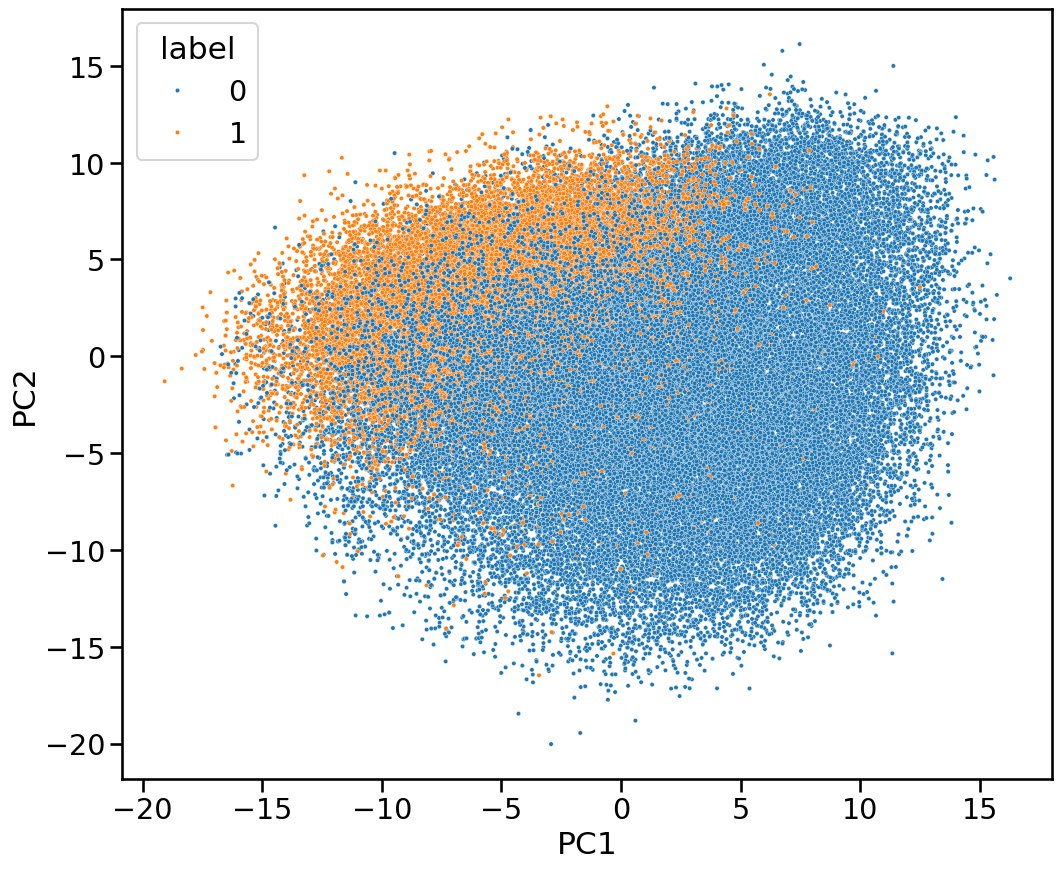

In [63]:
comp1 = 'PC1'
comp2 = 'PC2'


pcs_df = pd.DataFrame(data = pcs , 
        columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'])
pcs_df['label'] = y


plt.figure(figsize=(12,10))
with sns.plotting_context("talk",font_scale=1.25):
    sns.scatterplot(x=comp1, y=comp2,
                    data=pcs_df, 
                    hue="label",
                    s=10)
    plt.xlabel(comp1)
    plt.ylabel(comp2)
   
#plt.savefig("pca_chb_lbh_jer.png",
#                    format='png',dpi=150)